In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score , classification_report ,roc_auc_score

#Models 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [7]:
df=pd.read_csv('cleaned_telco_churn.csv')
df.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure_Bins_1-12,Tenure_Bins_13-24,Tenure_Bins_25-36,Tenure_Bins_37-48,Tenure_Bins_49-60,Tenure_Bins_61-72
0,0,29,29,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0
1,0,56,1889,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0
2,0,53,108,1,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0
3,0,42,1840,0,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0
4,0,70,151,1,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0


In [15]:
# Checking unique values to understand that the data is already preprocessed
not_inc = df.drop(columns=['MonthlyCharges','TotalCharges'])
for col in df.columns:
    if col in not_inc:
        print(f"{col}:{df[col].unique()}")
        print('-'*50)

SeniorCitizen:[0 1]
--------------------------------------------------
Churn:[0 1]
--------------------------------------------------
gender_Female:[1 0]
--------------------------------------------------
gender_Male:[0 1]
--------------------------------------------------
Partner_No:[0 1]
--------------------------------------------------
Partner_Yes:[1 0]
--------------------------------------------------
Dependents_No:[1 0]
--------------------------------------------------
Dependents_Yes:[0 1]
--------------------------------------------------
PhoneService_No:[1 0]
--------------------------------------------------
PhoneService_Yes:[0 1]
--------------------------------------------------
MultipleLines_No:[0 1]
--------------------------------------------------
MultipleLines_No phone service:[1 0]
--------------------------------------------------
MultipleLines_Yes:[0 1]
--------------------------------------------------
InternetService_DSL:[1 0]
------------------------------------

* All the featuers seem to be in correct format (One Hot Encoded).
* Only the **Monthly Charges** and **Total Charges** columns need to be scaled.

<Axes: xlabel='Churn'>

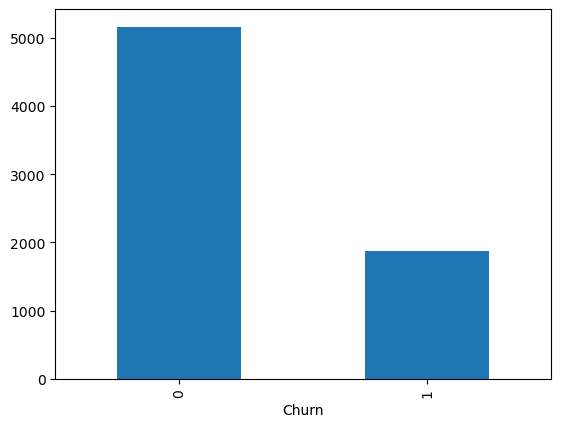

In [20]:
# Check for imbalance in target column 
df['Churn'].value_counts().plot(kind='bar')

* There is high imbalance in Target column.

### Splitting the data.

In [26]:
X=df.drop(columns='Churn')
y=df['Churn']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [36]:
# Compute scale_pos_weight for xgboost model as the data is imnbalanced.
neg,pos = np.bincount(y_train)
scale_pos_weight= neg/pos

### Build the preprocessing and model training pipeline.

In [45]:
models={
    'Logistic Regression':Pipeline([
        ('scaler',StandardScaler()),
        ('model',LogisticRegression(max_iter=1000,class_weight='balanced')) # class_weight will handle any imbalance in the data . 
    ]),
    'Decision Tree':Pipeline([
        ('model',DecisionTreeClassifier(class_weight='balanced',random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('model',RandomForestClassifier(random_state=42,class_weight='balanced'))
    ]),
    'Xgboost':Pipeline([
        ('model',XGBClassifier(eval_metric="logloss", scale_pos_weight=scale_pos_weight, random_state=42))
    ])
}

#### 1. Model Training 

In [65]:
cv_results={}
final_results={}
for name,pipeline in models.items():
    cv_scores=cross_val_score(pipeline,X_train,y_train,cv=5,scoring='accuracy')

    # Training 
    pipeline.fit(X_train,y_train)
    y_pred=pipeline.predict(X_test) 

    #metrics 
    acc=accuracy_score(y_test,y_pred)
    roc_auc=roc_auc_score(y_test,y_pred)

    #Evaluation
    cv_results[name]=cv_scores
    final_results[name]={
        "Cv mean Accuracy":np.mean(cv_scores),
        "Test Accuracy":acc,
        "Test Roc-Auc": roc_auc  
    }
    print(f"\n{name}:")
    print(f"CV Accuracy:{cv_scores}")
    print(f"Mean CV Accuracy:{np.mean(cv_scores)}")
    print(classification_report(y_test,y_pred))
    print('-'*50)




Logistic Regression:
CV Accuracy:[0.73955556 0.76533333 0.75022222 0.73777778 0.76977778]
Mean CV Accuracy:0.7525333333333333
              precision    recall  f1-score   support

           0       0.90      0.70      0.78      1033
           1       0.48      0.78      0.59       374

    accuracy                           0.72      1407
   macro avg       0.69      0.74      0.69      1407
weighted avg       0.79      0.72      0.73      1407

--------------------------------------------------

Decision Tree:
CV Accuracy:[0.73777778 0.75377778 0.73066667 0.736      0.76266667]
Mean CV Accuracy:0.7441777777777777
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1033
           1       0.47      0.49      0.48       374

    accuracy                           0.71      1407
   macro avg       0.64      0.64      0.64      1407
weighted avg       0.72      0.71      0.72      1407

-----------------------------------------------

In [51]:
# Comparison Table
results_df = pd.DataFrame(final_results).T
print("\n Model Comparison:\n", results_df)


 Model Comparison:
                      Cv mean Accuracy  Test Accuracy  Test Roc-Auc
Logistic Regression          0.752533       0.718550      0.736684
Decision Tree                0.744178       0.714996      0.644712
Random Forest                0.779022       0.771855      0.676612
Xgboost                      0.758044       0.753376      0.730551


#### Visual Comparison

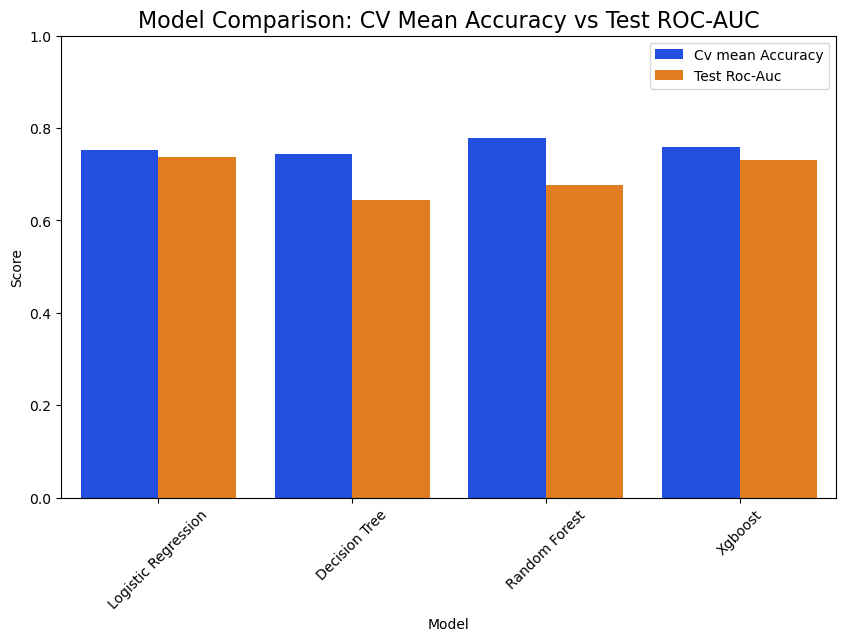

In [63]:
results_viz = results_df.reset_index().melt(id_vars='index', 
                                            value_vars=['Cv mean Accuracy', 'Test Roc-Auc'],
                                            var_name='Metric', value_name='Score')
results_viz.rename(columns={'index':'Model'}, inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(data=results_viz, x='Model', y='Score', hue='Metric', palette='bright')
plt.title("Model Comparison: CV Mean Accuracy vs Test ROC-AUC", fontsize=16)
plt.ylim(0,1)
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()

### Consideration for final choice of model - 
* **Imbalanced problem (churn)** - ROC-AUC is often more important than accuracy, because it measures how well the model discriminates churners vs non-churners.
#### Picking Xgboost -
* Accuracy is competitive (0.7534)
* ROC-AUC is high (0.7306), better reflecting class imbalance performance

## Training with XGBoost

In [69]:
# Training with minimal hyperparameter tuning
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=42,   
)

In [71]:
xgb_model.fit(X_train,y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [73]:
# make predictions 
y_pred1=xgb_model.predict(X_test)
y_proba=xgb_model.predict_proba(X_test)[:,1] # Probabilities for ROC-AUC


In [75]:
acc=accuracy_score(y_test,y_pred1)
rac=roc_auc_score(y_test,y_proba)
print(f"Test Accuracy:{acc:.2f}")
print(f"Test ROC_AUC:{rac:.2f}")

Test Accuracy:0.73
Test ROC_AUC:0.83


In [77]:
print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1033
           1       0.50      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.80      0.73      0.75      1407



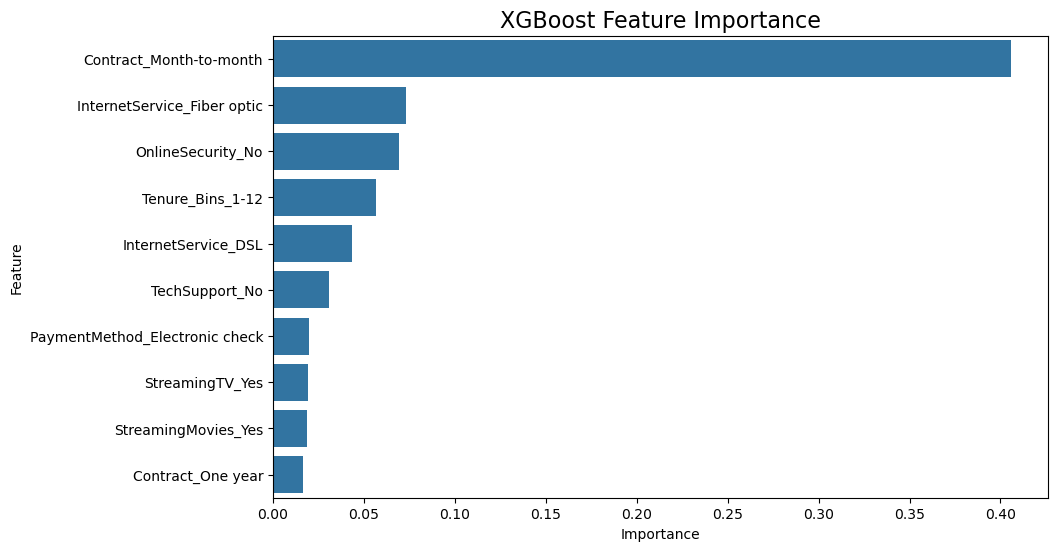

In [85]:
# Top 15 features important for prediction. 
feat_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_importance, x="Importance", y="Feature", dodge=False)
plt.title("XGBoost Feature Importance", fontsize=16)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

#### Saving the model 


In [88]:
import joblib
# Save the model
joblib.dump(xgb_model, "xgboost_churn_model.pkl")


['xgboost_churn_model.pkl']